# Зависимости

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import kagglehub

from tqdm.notebook import tqdm, tnrange
from itertools import batched

import shutil
from google.colab import drive
import os
from typing import Tuple, List
import random as rn
import copy
import gc

import cv2
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid

# Фильтрация набора данных (202,5k -> 20k)

## Загрузка датафрейма с атрибутами

In [3]:
!gdown 1VwRwgU3Gzg7j7sxiYGqmzAU09ULKt4_8
!unzip /content/list_attr_celeba.csv.zip
!rm /content/list_attr_celeba.csv.zip

Downloading...
From: https://drive.google.com/uc?id=1VwRwgU3Gzg7j7sxiYGqmzAU09ULKt4_8
To: /content/list_attr_celeba.csv.zip
100% 2.12M/2.12M [00:00<00:00, 109MB/s]
Archive:  /content/list_attr_celeba.csv.zip
  inflating: list_attr_celeba.csv    


In [5]:
# drive.mount('/content/drive', force_remount=True)

In [6]:
df = pd.read_csv('/content/list_attr_celeba.csv')
df

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0       000001.jpg                -1                1           1   
1       000002.jpg                -1               -1          -1   
2       000003.jpg                -1               -1          -1   
3       000004.jpg                -1               -1           1   
4       000005.jpg                -1                1           1   
...            ...               ...              ...         ...   
202594  202595.jpg                -1               -1           1   
202595  202596.jpg                -1               -1          -1   
202596  202597.jpg                -1               -1          -1   
202597  202598.jpg                -1                1           1   
202598  202599.jpg                -1                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                    -1    -1     -1        -1        -1          -1  ...   
1                     1    -1     -1        -1         1          -1  ...   
2                    -1    -1     -1         1        -1          -1  ...   
3                    -1    -1     -1        -1        -1          -1  ...   
4                    -1    -1     -1         1        -1          -1  ...   
...                 ...   ...    ...       ...       ...         ...  ...   
202594               -1    -1     -1         1        -1          -1  ...   
202595               -1    -1      1         1        -1          -1  ...   
202596               -1    -1     -1        -1        -1           1  ...   
202597               -1    -1     -1         1        -1           1  ...   
202598               -1    -1     -1        -1        -1          -1  ...   

        Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
0              -1        1              1         -1                 1   
1              -1        1             -1         -1                -1   
2              -1       -1             -1          1                -1   
3              -1       -1              1         -1                 1   
4              -1       -1             -1         -1                -1   
...           ...      ...            ...        ...               ...   
202594         -1       -1             -1         -1                -1   
202595         -1        1              1         -1                -1   
202596         -1        1             -1         -1                -1   
202597         -1        1             -1          1                 1   
202598         -1       -1             -1          1                -1   

        Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
0                -1                 1                -1               -1   
1                -1                -1                -1               -1   
2                -1                -1                -1               -1   
3                -1                 1                 1               -1   
4                -1                 1                -1               -1   
...             ...               ...               ...              ...   
202594           -1                 1                -1               -1   
202595           -1                -1                -1               -1   
202596           -1                -1                -1               -1   
202597           -1                 1                -1               -1   
202598           -1                 1                -1               -1   

        Young  
0           1  
1           1  
2           1  
3           1  
4           1  
...       ...  
202594      1  
202595      1  
202596      1  
202597      1  
202598      1  

[202599 rows x 41 columns]

Загрузка Identities

In [7]:
!gdown 13xL4miYtAuY3ZsoRbiCkGi5lq2HH__nm

Downloading...
From: https://drive.google.com/uc?id=13xL4miYtAuY3ZsoRbiCkGi5lq2HH__nm
To: /content/identity_CelebA.txt
100% 3.42M/3.42M [00:00<00:00, 96.2MB/s]


In [8]:
id_df = pd.read_csv('identity_CelebA.txt', header=None, sep='\\s+')
id_df.columns=['image_id', 'identity']

# добавление меток классов
df = pd.merge(df, id_df, on='image_id', how='left')
df

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0       000001.jpg                -1                1           1   
1       000002.jpg                -1               -1          -1   
2       000003.jpg                -1               -1          -1   
3       000004.jpg                -1               -1           1   
4       000005.jpg                -1                1           1   
...            ...               ...              ...         ...   
202594  202595.jpg                -1               -1           1   
202595  202596.jpg                -1               -1          -1   
202596  202597.jpg                -1               -1          -1   
202597  202598.jpg                -1                1           1   
202598  202599.jpg                -1                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                    -1    -1     -1        -1        -1          -1  ...   
1                     1    -1     -1        -1         1          -1  ...   
2                    -1    -1     -1         1        -1          -1  ...   
3                    -1    -1     -1        -1        -1          -1  ...   
4                    -1    -1     -1         1        -1          -1  ...   
...                 ...   ...    ...       ...       ...         ...  ...   
202594               -1    -1     -1         1        -1          -1  ...   
202595               -1    -1      1         1        -1          -1  ...   
202596               -1    -1     -1        -1        -1           1  ...   
202597               -1    -1     -1         1        -1           1  ...   
202598               -1    -1     -1        -1        -1          -1  ...   

        Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  \
0             1              1         -1                 1           -1   
1             1             -1         -1                -1           -1   
2            -1             -1          1                -1           -1   
3            -1              1         -1                 1           -1   
4            -1             -1         -1                -1           -1   
...         ...            ...        ...               ...          ...   
202594       -1             -1         -1                -1           -1   
202595        1              1         -1                -1           -1   
202596        1             -1         -1                -1           -1   
202597        1             -1          1                 1           -1   
202598       -1             -1          1                -1           -1   

        Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young  identity  
0                      1                -1               -1      1      2880  
1                     -1                -1               -1      1      2937  
2                     -1                -1               -1      1      8692  
3                      1                 1               -1      1      5805  
4                      1                -1               -1      1      9295  
...                  ...               ...              ...    ...       ...  
202594                 1                -1               -1      1      9761  
202595                -1                -1               -1      1      7192  
202596                -1                -1               -1      1      9852  
202597                 1                -1               -1      1      5570  
202598                 1                -1               -1      1     10101  

[202599 rows x 42 columns]

In [45]:
df.identity.nunique()

10177

Итого 10,177 уникальных классов, и в среднем / по медиане около 20 изображений на класс.

In [46]:
df.identity.value_counts().describe().round(2)

count    10177.00
mean        19.91
std          8.93
min          1.00
25%         13.00
50%         21.00
75%         29.00
max         35.00
Name: count, dtype: float64

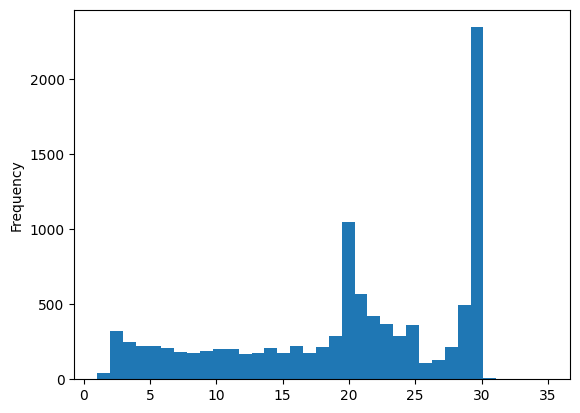

In [ ]:
df.identity.value_counts().plot(kind='hist', bins=35);

Посмотрим на признаки и оценим распределения; поскольку все они бинарные (-1/1), достаточно среднего значения и стандартного отклонения.

In [ ]:
df.columns[:-1]

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
df.describe().T.iloc[:-1, [1,2]]

mean       std
5_o_Clock_Shadow    -0.777728  0.628602
Arched_Eyebrows     -0.466039  0.884766
Attractive           0.025010  0.999690
Bags_Under_Eyes     -0.590857  0.806778
Bald                -0.955113  0.296241
Bangs               -0.696849  0.717219
Big_Lips            -0.518408  0.855135
Big_Nose            -0.530935  0.847414
Black_Hair          -0.521498  0.853255
Blond_Hair          -0.704016  0.710186
Blurry              -0.898203  0.439582
Brown_Hair          -0.589613  0.807688
Bushy_Eyebrows      -0.715665  0.698445
Chubby              -0.884866  0.465846
Double_Chin         -0.906623  0.421942
Eyeglasses          -0.869762  0.493472
Goatee              -0.874471  0.485079
Gray_Hair           -0.916100  0.400950
Heavy_Makeup        -0.226156  0.974093
High_Cheekbones     -0.089936  0.995950
Male                -0.166491  0.986045
Mouth_Slightly_Open -0.033144  0.999453
Mustache            -0.916910  0.399096
Narrow_Eyes         -0.769703  0.638404
No_Beard             0.669880  0.742471
Oval_Face           -0.431715  0.902012
Pale_Skin           -0.914106  0.405476
Pointy_Nose         -0.445111  0.895478
Receding_Hairline   -0.840443  0.541901
Rosy_Cheeks         -0.868558  0.495589
Sideburns           -0.886979  0.461811
Smiling             -0.035839  0.999360
Straight_Hair       -0.583196  0.812333
Wavy_Hair           -0.360866  0.932620
Wearing_Earrings    -0.622150  0.782900
Wearing_Hat         -0.903079  0.429475
Wearing_Lipstick    -0.055129  0.998482
Wearing_Necklace    -0.754066  0.656800
Wearing_Necktie     -0.854570  0.519338
Young                0.547234  0.836982

Итоговый подход к фильтрации и стратификации набора CelebA

**Цель**

Отобрать 10,000+ высококачественных изображений из датасета CelebA для задачи face recognition с акцентом на разнообразие и сбалансированность признаков.

---

**Стратегия фильтрации (на примере 10,000 изображений)**

1. Критический фильтр (качество изображения):

    - Исключаются все размытые изображения (Blurry = 1); зашумление можно внести подконтрольно при необходимости.

2. Стратификация по гендеру:

    - Цель: 50/50 баланс (5,000 мужчин, 5,000 женщин)
    - Признак: Male (основной стратифицирующий признак)

3. Вложенная стратификация по возрасту:

    - Внутри каждой гендерной группы: 50% Young = 1, 50% Young = -1
    - Итого: 2,500 молодых мужчин, 2,500 не молодых мужчин, 2,500 молодых женщин, 2,500 не молодых женщин

4. Внутренняя балансировка в подгруппах:

    - Аксессуары: Eyeglasses, Wearing_Hat, Wearing_Earrings, Wearing_Necktie, Wearing_Necklace
    - Волосы: Bangs, Black_Hair, Blond_Hair, Brown_Hair, Gray_Hair, Straight_Hair, Wavy_Hair

5. Исключения из активной стратификации

Следующие признаки не используются для активного балансирования, полагаемся на центральную предельную теорему:

    - Гендерно-коррелированные: Heavy_Makeup, Wearing_Lipstick, Mustache, Goatee, 5_o_Clock_Shadow, Sideburns
    - Анатомические черты: Big_Lips, Big_Nose, High_Cheekbones, Pointy_Nose, Oval_Face, Narrow_Eyes
    - Состояние: Bags_Under_Eyes, Chubby, Double_Chin
    - Почти константные: Attractive, Smiling, Mouth_Slightly_Open

Обоснование

    - Гендерно-коррелированные признаки автоматически сбалансируются через гендерную стратификацию
    - Аксессуары и волосы важны для робастности face recognition (модель должна работать с разными аксессуарами и прическами)
    - Анатомические черты доверяем статистике при 10K размере выборки
    - Качество обеспечивается через исключение размытых изображений и естественную селекцию при высоком качестве фильтрации

---

**Ожидаемый результат**

Итоговый набор = подмножество из 10,000 изображений с контролируемым балансом по ключевым демографическим признакам и разнообразием по вспомогательным атрибутам, подходящее для надежного обучения face recognition моделей.

In [9]:
def filter_celeba_dataset(df, n_samples=20000, n_classes_min=1000, samples_per_class_min=20, random_state=42):
    """
    Фильтрует набор со стратификацией по классам и атрибутам:
    1. Удалить размытые изображения.
    2. Стратифицировать по классам.
    3. Стратифицировать по полу (50/50).
    4. Стратифицировать по возрасту (50/50).
    5. Сбалансировать в когортах аксессуары и волосы.
    """
    # сид для воспроизводимости
    np.random.seed(random_state)

    print("Processing CelebA dataset with identity classes...")
    print(f"Original dataset size: {len(df)} images with {df['identity'].nunique()} unique classes")

    # удаляем размытые изображения, т.к. они снизят качество
    df_filtered = df[df['Blurry'] == -1].copy()
    print(f"After removing blurry images: {len(df_filtered)} images")

    # проверка на количество объектов в классе
    class_counts = df_filtered['identity'].value_counts()
    valid_classes = class_counts[class_counts >= samples_per_class_min].index
    df_filtered = df_filtered[df_filtered['identity'].isin(valid_classes)]

    print(f"After filtering classes with at least {samples_per_class_min} samples: {len(df_filtered)} images, {df_filtered['identity'].nunique()} classes\n")

    # набор признаков для балансировки
    accessory_features = ['Eyeglasses', 'Wearing_Hat', 'Wearing_Earrings', 'Wearing_Necktie', 'Wearing_Necklace']
    hair_features = ['Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'Bald']

    # целевые параметры для классовой стратификации
    target_classes_per_group = n_classes_min // 4  # ~250 классов на когорту (пол-возраст)
    target_samples_per_group = n_samples // 4  # ~5000 объектов на когорту

    # когорты (пол-возраст)
    groups_info = [
        ((df_filtered['Male'] == 1) & (df_filtered['Young'] == 1), "Male Young"),
        ((df_filtered['Male'] == 1) & (df_filtered['Young'] == -1), "Male Not Young"),
        ((df_filtered['Male'] == -1) & (df_filtered['Young'] == 1), "Female Young"),
        ((df_filtered['Male'] == -1) & (df_filtered['Young'] == -1), "Female Not Young")
    ]

    selected_groups = []

    for condition, group_name in groups_info:
        group_data = df_filtered[condition].copy()

        print(f"{group_name}: {len(group_data)} available images from {group_data['identity'].nunique()} classes, targeting {target_samples_per_group} samples and {target_classes_per_group} classes")

        # уникальные классы в каждой когорте
        group_classes = group_data['identity'].value_counts()
        available_classes = group_classes.index.tolist()

        # выбрать доступные
        selected_classes = available_classes[:min(target_classes_per_group, len(available_classes))]

        if len(selected_classes) < target_classes_per_group:
            print(f"  Warning: Only {len(selected_classes)} classes available in {group_name}, expected {target_classes_per_group}")

        # для каждого класса взять объекты с учетом балансировки
        group_samples = []
        remaining_samples_needed = target_samples_per_group

        for identity in selected_classes:
            class_data = group_data[group_data['identity'] == identity].copy()

            # набрать необходимый минимум на каждый класс, распределить оставшихся
            min_samples = samples_per_class_min
            # обеспечить равномерное распределение по классам
            remaining_classes = len(selected_classes) - len(group_samples)
            additional_samples = max(0, remaining_samples_needed - (remaining_classes - 1) * min_samples)
            if remaining_classes > 0:
                additional_samples = min(additional_samples, remaining_samples_needed)
            else:
                additional_samples = 0

            samples_to_take = min(len(class_data), min_samples + max(0, additional_samples // remaining_classes))
            samples_to_take = max(samples_per_class_min, samples_to_take)

            if samples_to_take > 0 and len(class_data) >= samples_to_take:
                # внутренняя балансировка по аксессуарам и волосам для класса внутри когорты
                selected_indices = set()

                for feature in accessory_features + hair_features:
                    pos_samples = class_data[class_data[feature] == 1].index.tolist()
                    neg_samples = class_data[class_data[feature] == -1].index.tolist()

                    # пропорционально по всем атрибутам внутри класса
                    n_from_pos = min(len(pos_samples), max(1, samples_to_take // 20))
                    n_from_neg = min(len(neg_samples), max(1, samples_to_take // 20))

                    if pos_samples and n_from_pos > 0:
                        pos_selected = np.random.choice(pos_samples, size=min(n_from_pos, len(pos_samples)), replace=False)
                        selected_indices.update(pos_selected)

                    if neg_samples and n_from_neg > 0:
                        neg_selected = np.random.choice(neg_samples, size=min(n_from_neg, len(neg_samples)), replace=False)
                        selected_indices.update(neg_selected)

                selected_idx_list = list(selected_indices)

                # при недостаче дополнить случайными объектами
                if len(selected_idx_list) < samples_to_take:
                    remaining_indices = class_data.index.difference(selected_idx_list).tolist()
                    needed = samples_to_take - len(selected_idx_list)
                    if len(remaining_indices) >= needed:
                        additional = np.random.choice(remaining_indices, size=needed, replace=False).tolist()
                        selected_idx_list.extend(additional)
                    else:
                        # добавить всех оставшихся из этого класса
                        selected_idx_list.extend(remaining_indices)

                # итоговая подвыборка для класса внутри когорты
                class_samples = class_data.loc[selected_idx_list[:samples_to_take]]
                group_samples.append(class_samples)
                remaining_samples_needed -= len(class_samples)
            elif samples_to_take > 0:
                # при недостаче -- собрать всех доступных
                class_samples = class_data
                group_samples.append(class_data)
                remaining_samples_needed -= len(class_data)
                print(f"    Warning: Class {identity} has only {len(class_data)} samples, taking all")

        if group_samples:
            # объединить объекты классов в в когорту
            group_combined = pd.concat(group_samples, ignore_index=True)
            selected_groups.append(group_combined)
        else:
            # нет подходящих -- выбрать случайных
            print(f"  Warning: No valid classes found for {group_name}, taking random samples")
            if len(group_data) >= target_samples_per_group:
                random_samples = group_data.sample(n=target_samples_per_group, random_state=random_state)
                selected_groups.append(random_samples)
            else:
                selected_groups.append(group_data)

    # объединить когорты
    final_dataset = pd.concat(selected_groups, ignore_index=True)

    # обработка недостачи из-за ограничений внутри классов
    if len(final_dataset) < n_samples:
        print(f"Warning: Only {len(final_dataset)} samples after class/group selection, trying to supplement...")

        used_image_ids = set(final_dataset['image_id'])
        used_classes = set(final_dataset['identity'])

        # добрать объекты по уже представленным классам
        remaining_same_classes = df_filtered[
            (~df_filtered['image_id'].isin(used_image_ids)) &
            (df_filtered['identity'].isin(used_classes))
        ]

        if len(remaining_same_classes) > 0:
            additional_needed = n_samples - len(final_dataset)
            if len(remaining_same_classes) >= additional_needed:
                additional_samples = remaining_same_classes.sample(n=additional_needed, random_state=random_state+100)
            else:
                additional_samples = remaining_same_classes
                print(f"  Could only add {len(additional_samples)} additional samples from existing classes")

            final_dataset = pd.concat([final_dataset, additional_samples], ignore_index=True)

    # если попали лишние, обрезать до n_samples
    if len(final_dataset) > n_samples:
        final_dataset = final_dataset.sample(n=n_samples, random_state=random_state).reset_index(drop=True)

    print(f"\nFinal dataset composition:")
    print(f"Total samples: {len(final_dataset)}")
    print(f"Total unique classes: {final_dataset['identity'].nunique()}")

    # подсчет объектов в когортах
    male_count = (final_dataset['Male'] == 1).sum()
    female_count = (final_dataset['Male'] == -1).sum()
    young_count = (final_dataset['Young'] == 1).sum()
    not_young_count = (final_dataset['Young'] == -1).sum()

    print(f"Males: {male_count}, Females: {female_count}")
    print(f"Young: {young_count}, Not Young: {not_young_count}")

    # разбивка по когортам
    my_count = len(final_dataset[(final_dataset['Male'] == 1) & (final_dataset['Young'] == 1)])
    mny_count = len(final_dataset[(final_dataset['Male'] == 1) & (final_dataset['Young'] == -1)])
    fy_count = len(final_dataset[(final_dataset['Male'] == -1) & (final_dataset['Young'] == 1)])
    fny_count = len(final_dataset[(final_dataset['Male'] == -1) & (final_dataset['Young'] == -1)])

    print(f"\nDetailed breakdown:")
    print(f"  Male Young: {my_count} samples from {final_dataset[(final_dataset['Male'] == 1) & (final_dataset['Young'] == 1)]['identity'].nunique()} classes")
    print(f"  Male Not Young: {mny_count} samples from {final_dataset[(final_dataset['Male'] == 1) & (final_dataset['Young'] == -1)]['identity'].nunique()} classes")
    print(f"  Female Young: {fy_count} samples from {final_dataset[(final_dataset['Male'] == -1) & (final_dataset['Young'] == 1)]['identity'].nunique()} classes")
    print(f"  Female Not Young: {fny_count} samples from {final_dataset[(final_dataset['Male'] == -1) & (final_dataset['Young'] == -1)]['identity'].nunique()} classes")

    # вывести распределение признаков аксессуары/волосы вследствие балансировки
    print(f"\nAccessory distribution (verification of internal balancing):")
    for i, acc in enumerate(accessory_features, 1):
        with_acc = (final_dataset[acc] == 1).sum()
        without_acc = (final_dataset[acc] == -1).sum()
        print(f"  {i}. {acc}: {with_acc} with, {without_acc} without")

    print(f"\nHair distribution (verification of internal balancing):")
    for i, hair in enumerate(hair_features, 1):
        with_hair = (final_dataset[hair] == 1).sum()
        without_hair = (final_dataset[hair] == -1).sum()
        print(f"  {i}. {hair}: {with_hair} with, {without_hair} without")

    return final_dataset[['image_id']].copy(), final_dataset.copy()

In [10]:
filtered_subset_id, filtered_subset = filter_celeba_dataset(
        df,
        n_samples=(20_000),
        n_classes_min=1000,
        samples_per_class_min=20,
        random_state=42)

# сортировка по id, добавление путей
filtered_subset = filtered_subset.sort_values('image_id').reset_index(drop=True)
image_int = filtered_subset['image_id'].str[:-4].astype(int)
image_part = (image_int // 10_000) + (image_int % 10_000 != 0)
filtered_subset['image_path'] = image_part.apply(lambda x: f'Part {x}/' * 2) + filtered_subset['image_id']

output_path = 'list_attr_celeba_filtered.csv'
filtered_subset.to_csv(output_path, index=False)

print(f"\nFiltered dataset saved to: /content/{output_path}")
print(f"Number of selected images: {len(filtered_subset_id)}")

Processing CelebA dataset with identity classes...
Original dataset size: 202599 images with 10177 unique classes
After removing blurry images: 192287 images
After filtering classes with at least 20 samples: 146417 images, 5769 classes

Male Young: 37658 available images from 2019 classes, targeting 5000 samples and 250 classes
Male Not Young: 18170 available images from 1171 classes, targeting 5000 samples and 250 classes
Female Young: 81141 available images from 3414 classes, targeting 5000 samples and 250 classes
Female Not Young: 9448 available images from 850 classes, targeting 5000 samples and 250 classes

Final dataset composition:
Total samples: 20000
Total unique classes: 1000
Males: 10011, Females: 9989
Young: 10007, Not Young: 9993

Detailed breakdown:
  Male Young: 5003 samples from 250 classes
  Male Not Young: 5008 samples from 250 classes
  Female Young: 5004 samples from 250 classes
  Female Not Young: 4985 samples from 250 classes

Accessory distribution (verification 

In [11]:
filtered_subset

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0      000007.jpg                 1               -1           1   
1      000018.jpg                -1                1          -1   
2      000024.jpg                -1                1           1   
3      000051.jpg                 1               -1          -1   
4      000052.jpg                -1               -1          -1   
...           ...               ...              ...         ...   
19995  202548.jpg                -1                1          -1   
19996  202559.jpg                -1                1           1   
19997  202560.jpg                -1                1          -1   
19998  202561.jpg                -1               -1          -1   
19999  202581.jpg                 1               -1          -1   

       Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                    1    -1     -1         1         1           1  ...   
1                   -1    -1     -1        -1         1          -1  ...   
2                   -1    -1     -1         1        -1          -1  ...   
3                    1     1     -1        -1         1          -1  ...   
4                    1    -1     -1        -1         1          -1  ...   
...                ...   ...    ...       ...       ...         ...  ...   
19995                1    -1     -1        -1        -1          -1  ...   
19996               -1    -1      1         1        -1          -1  ...   
19997               -1    -1     -1         1        -1          -1  ...   
19998                1     1     -1         1         1          -1  ...   
19999                1    -1     -1        -1        -1          -1  ...   

       Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  \
0                  1         -1                -1           -1   
1                 -1          1                 1           -1   
2                 -1         -1                 1           -1   
3                 -1         -1                -1           -1   
4                  1         -1                -1           -1   
...              ...        ...               ...          ...   
19995             -1         -1                 1           -1   
19996             -1          1                -1           -1   
19997             -1          1                 1           -1   
19998             -1         -1                -1           -1   
19999             -1          1                -1           -1   

       Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young  identity  \
0                    -1                -1               -1      1      9040   
1                     1                 1               -1     -1      2464   
2                     1                 1               -1      1      9290   
3                    -1                -1               -1     -1      1446   
4                    -1                -1               -1     -1      3896   
...                 ...               ...              ...    ...       ...   
19995                 1                 1               -1     -1      7095   
19996                 1                 1               -1     -1      5768   
19997                 1                -1               -1     -1      6494   
19998                -1                -1                1     -1      8787   
19999                -1                -1                1     -1      7902   

                       image_path  
0        Part 1/Part 1/000007.jpg  
1        Part 1/Part 1/000018.jpg  
2        Part 1/Part 1/000024.jpg  
3        Part 1/Part 1/000051.jpg  
4        Part 1/Part 1/000052.jpg  
...                           ...  
19995  Part 21/Part 21/202548.jpg  
19996  Part 21/Part 21/202559.jpg  
19997  Part 21/Part 21/202560.jpg  
19998  Part 21/Part 21/202561.jpg  
19999  Part 21/Part 21/202581.jpg  

[20000 rows x 43 columns]

In [12]:
filtered_subset.identity.value_counts().describe().round(2)

count    1000.00
mean       20.00
std         0.35
min        18.00
25%        20.00
50%        20.00
75%        20.00
max        21.00
Name: count, dtype: float64

## **Обоснование стратегии фильтрации датасета CelebA**

## 1. Исходный набор
Датасет CelebA содержит 202,599 изображений лиц знаменитостей (10,177 уникальных классов) с 40 бинарными атрибутами. Набор включает разнообразные изображения в естественных условиях, но также содержит размытые изображения и несбалансированные распределения по некоторым атрибутам.

## 2. Задача
Необходимо было сформировать подмножество из 20,000 изображений для задачи face recognition с целью:
- Ускорения обучения моделей за счет снижения вычислительной нагрузки
- Обеспечения контролируемого и сбалансированного набора данных
- Повышения робастности модели к различным внешним факторам
- Обеспечения достаточной представленности по классам (1000 уникальных классов, 19-20 изображений на каждый класс)

## 3. Процесс формирования итоговой стратегии
Изначально рассматривались подходы:
- **Качественная оценка изображений** через комплексный quality score → **отклонен**, так как субъективность оценки может ввести смещение
- **Стратификация по всем атрибутам** → **отклонен**, так как создает чрезмерную сложность и может нарушить естественные корреляции
- **Факторный анализ и укрупнение признаков** → **отклонен**, так как не хватает статистической мощности (разная представленность признаков) и теряется интерпретируемость

**Сформулированы следующие опорные принципы приоритизации:**
- **Иерархия важности**: Классовая стратификация как основа
- **Гендерно-возрастная стратификация**: Внутри классов обеспечивается баланс по полу и возрасту
- **Естественные корреляции**: Признаки, сильно связанные с полом (макияж, лицевая растительность), автоматически сбалансируются
- **Практическая значимость**: Аксессуары и волосы важны для робастности модели
- **Центральная предельная теорема**: Для остальных признаков при размере выборки в 20к доверяем статистике

## 4. Итоговая стратегия

### Что делаем и почему:
- **Критический фильтр**: Удаляем размытые изображения (Blurry=1) → критично для face recognition
- **Классовая стратификация**: 1000 классов, 19-20 изображений на каждый класс → обеспечивает разнообразие по лицам
- **Гендерная стратификация**: 50/50 баланс (~10K мужчин, ~10K женщин) → обеспечивает равную представленность
- **Возрастная стратификация**: 50/50 баланс по возрасту внутри каждого пола → контролирует возрастные эффекты
- **Внутренняя балансировка**: В каждой из 4 групп (пол-возраст) обеспечиваем разнообразие по аксессуарам и волосам → повышает робастность модели

### Что не делаем и почему:
- **Не балансируем косметику и лицевую растительность** → автоматически сбалансируются через гендерную стратификацию
- **Не используем сложные весовые схемы** → усложняют интерпретацию и могут ввести новые смещения
- **Не стратифицируем анатомические черты** → доверяем ЦПТ в силу размера выборки
- **Не исключаем признаки на основе распределений** → сохраняем разнообразие для обобщающей способности

## 5. Результирующий набор
Финальное подмножество содержит 20,000 изображений с:
- Классовой разнообразностью: 1000 уникальных классов, 19-20 изображений на каждый класс
- Точным балансом по полу (10,000/10,000) по признаку Male
- Точным балансом по возрасту (10,000/10,000) по признаку Young
- Четким разделением на 4 равные половозрастные группы/когорты (5,000 каждая) по комбинациям `Male` и `Young`
- Разнообразным представительством по аксессуарам: `Eyeglasses`, `Wearing_Hat`, `Wearing_Earrings`, `Wearing_Necktie`, `Wearing_Necklace`
- Разнообразным представительством по волосам: `Bangs`, `Black_Hair`, `Blond_Hair`, `Brown_Hair`, `Gray_Hair`, `Straight_Hair`, `Wavy_Hair`
- Отсутствием размытых изображений (фильтр по `Blurry`)
- Сохранением естественных корреляций между атрибутами (опираясь на ЦПТ, принимаем допущение, что распределения признаков в наборе соответствуют таковым в генеральной совокупности)

Подмножество оптимально сбалансировано для надежного обучения face recognition моделей с минимальным смещением и максимальной робастностью. Итоговый набор включает разнообразные изображения в естественных условиях, где каждый класс (`identity`) представлен не менее чем 19 изображениями, всего 1000 уникальных классов.

## Сохранение отфильтрованного набора

In [51]:
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [52]:
# Загрузка исходного набора в хранилище Google Colab (3-4 минуты при "удачном" сервере у ВМ колаба, иначе -- ~15).
# Распаковка (еще ~6 минут). Итого 10-20 минут (в Kaggle быстрее, около 8 минут).

path = kagglehub.dataset_download("kevinpatel04/celeba-original-wild-images")

print("Path to dataset files:", path)

100%|██████████| 17.3G/17.3G [03:19<00:00, 92.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1


In [53]:
# Сохранение отобранных изображений в папку `filtered` (1 минута)

destination_folder = f"/content/filtered/"
os.makedirs(destination_folder, exist_ok=True)
image_paths = filtered_subset['image_path'].tolist()

for img_path in tqdm(image_paths):
    full_path = f'{path}/{img_path}'
    shutil.copy(full_path, destination_folder)

  0%|          | 0/20000 [00:00<?, ?it/s]

Архивирование и перенос на Google Drive

In [ ]:
# 3-5 минут
!zip -rq filtered.zip filtered

In [55]:
source = "/content/filtered.zip"
destination = "/content/drive/MyDrive/DLS/FR/filtered.zip"

shutil.copy(source, destination)

'/content/drive/MyDrive/DLS/FR/filtered.zip'

# Face Alignment

## BBoxes

In [58]:
# загрузка файла с координатами ббоксов: `list_bbox_celeba.csv`
!gdown 13TeWaEiBoC3MdySD3_PTLovR2FU7C3CI

Downloading...
From: https://drive.google.com/uc?id=13TeWaEiBoC3MdySD3_PTLovR2FU7C3CI
To: /content/list_bbox_celeba.csv
100% 5.39M/5.39M [00:00<00:00, 74.4MB/s]


In [59]:
filtered_ids = filtered_subset['image_id'].tolist()

In [60]:
bbox_df = pd.read_csv('list_bbox_celeba.csv')
bbox_df_filtered = bbox_df.query('image_id in @filtered_ids')
bbox_df_filtered

image_id  x_1  y_1  width  height
6       000007.jpg   64   93    211     292
17      000018.jpg  140   84    195     270
23      000024.jpg  753  127    114     158
50      000051.jpg   61   98    255     353
51      000052.jpg  135  159    333     461
...            ...  ...  ...    ...     ...
202547  202548.jpg  126   31    127     176
202558  202559.jpg  121  102    239     331
202559  202560.jpg  115  155    185     256
202560  202561.jpg   94   46    205     284
202580  202581.jpg   85   88    195     270

[20000 rows x 5 columns]

In [61]:
df_bbx = pd.merge(filtered_subset, bbox_df_filtered, how='left', on='image_id')
df_bbx

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0      000007.jpg                 1               -1           1   
1      000018.jpg                -1                1          -1   
2      000024.jpg                -1                1           1   
3      000051.jpg                 1               -1          -1   
4      000052.jpg                -1               -1          -1   
...           ...               ...              ...         ...   
19995  202548.jpg                -1                1          -1   
19996  202559.jpg                -1                1           1   
19997  202560.jpg                -1                1          -1   
19998  202561.jpg                -1               -1          -1   
19999  202581.jpg                 1               -1          -1   

       Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                    1    -1     -1         1         1           1  ...   
1                   -1    -1     -1        -1         1          -1  ...   
2                   -1    -1     -1         1        -1          -1  ...   
3                    1     1     -1        -1         1          -1  ...   
4                    1    -1     -1        -1         1          -1  ...   
...                ...   ...    ...       ...       ...         ...  ...   
19995                1    -1     -1        -1        -1          -1  ...   
19996               -1    -1      1         1        -1          -1  ...   
19997               -1    -1     -1         1        -1          -1  ...   
19998                1     1     -1         1         1          -1  ...   
19999                1    -1     -1        -1        -1          -1  ...   

       Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young  identity  \
0                    -1                -1               -1      1      9040   
1                     1                 1               -1     -1      2464   
2                     1                 1               -1      1      9290   
3                    -1                -1               -1     -1      1446   
4                    -1                -1               -1     -1      3896   
...                 ...               ...              ...    ...       ...   
19995                 1                 1               -1     -1      7095   
19996                 1                 1               -1     -1      5768   
19997                 1                -1               -1     -1      6494   
19998                -1                -1                1     -1      8787   
19999                -1                -1                1     -1      7902   

                       image_path  x_1  y_1  width  height  
0        Part 1/Part 1/000007.jpg   64   93    211     292  
1        Part 1/Part 1/000018.jpg  140   84    195     270  
2        Part 1/Part 1/000024.jpg  753  127    114     158  
3        Part 1/Part 1/000051.jpg   61   98    255     353  
4        Part 1/Part 1/000052.jpg  135  159    333     461  
...                           ...  ...  ...    ...     ...  
19995  Part 21/Part 21/202548.jpg  126   31    127     176  
19996  Part 21/Part 21/202559.jpg  121  102    239     331  
19997  Part 21/Part 21/202560.jpg  115  155    185     256  
19998  Part 21/Part 21/202561.jpg   94   46    205     284  
19999  Part 21/Part 21/202581.jpg   85   88    195     270  

[20000 rows x 47 columns]

## Landmarks

In [62]:
# загрузка файла с координатами кллючевых точек: `list_landmarks_celeba.txt`
!gdown 1PdYpI5SPf-6NDZ2rTG9IRsXpmYoWADSF

Downloading...
From: https://drive.google.com/uc?id=1PdYpI5SPf-6NDZ2rTG9IRsXpmYoWADSF
To: /content/list_landmarks_celeba.txt
100% 12.4M/12.4M [00:00<00:00, 60.8MB/s]


In [63]:
lm_df = pd.read_table('list_landmarks_celeba.txt', sep='\\s+', header=1, index_col=None).reset_index(names=['image_id'])
lm_df_filtered = lm_df.query('image_id in @filtered_ids')
lm_df_filtered

image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  \
6       000007.jpg        129        198         204         190     163   
17      000018.jpg        200        181         284         187     238   
23      000024.jpg        788        184         833         216     798   
50      000051.jpg        139        225         243         231     173   
51      000052.jpg        237        325         348         290     304   
...            ...        ...        ...         ...         ...     ...   
202547  202548.jpg        165         95         211          94     188   
202558  202559.jpg        195        222         291         235     232   
202559  202560.jpg        172        247         242         228     222   
202560  202561.jpg        157        149         237         150     194   
202580  202581.jpg        145        185         228         186     186   

        nose_y  leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
6          242          140          277           202           271  
17         228          197          256           277           261  
23         209          766          228           801           257  
50         295          136          312           229           329  
51         383          282          450           380           418  
...        ...          ...          ...           ...           ...  
202547     114          171          143           208           143  
202558     295          187          314           285           326  
202559     285          195          316           256           299  
202560     196          147          228           244           229  
202580     225          148          259           219           261  

[20000 rows x 11 columns]

In [64]:
df_bbx_lm = pd.merge(df_bbx, lm_df_filtered, how='left', on='image_id')
df_bbx_lm

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0      000007.jpg                 1               -1           1   
1      000018.jpg                -1                1          -1   
2      000024.jpg                -1                1           1   
3      000051.jpg                 1               -1          -1   
4      000052.jpg                -1               -1          -1   
...           ...               ...              ...         ...   
19995  202548.jpg                -1                1          -1   
19996  202559.jpg                -1                1           1   
19997  202560.jpg                -1                1          -1   
19998  202561.jpg                -1               -1          -1   
19999  202581.jpg                 1               -1          -1   

       Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                    1    -1     -1         1         1           1  ...   
1                   -1    -1     -1        -1         1          -1  ...   
2                   -1    -1     -1         1        -1          -1  ...   
3                    1     1     -1        -1         1          -1  ...   
4                    1    -1     -1        -1         1          -1  ...   
...                ...   ...    ...       ...       ...         ...  ...   
19995                1    -1     -1        -1        -1          -1  ...   
19996               -1    -1      1         1        -1          -1  ...   
19997               -1    -1     -1         1        -1          -1  ...   
19998                1     1     -1         1         1          -1  ...   
19999                1    -1     -1        -1        -1          -1  ...   

       lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
0            129        198         204         190     163     242   
1            200        181         284         187     238     228   
2            788        184         833         216     798     209   
3            139        225         243         231     173     295   
4            237        325         348         290     304     383   
...          ...        ...         ...         ...     ...     ...   
19995        165         95         211          94     188     114   
19996        195        222         291         235     232     295   
19997        172        247         242         228     222     285   
19998        157        149         237         150     194     196   
19999        145        185         228         186     186     225   

       leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0              140          277           202           271  
1              197          256           277           261  
2              766          228           801           257  
3              136          312           229           329  
4              282          450           380           418  
...            ...          ...           ...           ...  
19995          171          143           208           143  
19996          187          314           285           326  
19997          195          316           256           299  
19998          147          228           244           229  
19999          148          259           219           261  

[20000 rows x 57 columns]

In [74]:
df_bbx_lm.to_csv('/content/drive/MyDrive/DLS/FR/celeba_filtered_full.csv', index=False)

## Загрузка с Google Colab (файлы расшарены)

In [75]:
# drive.mount('/content/drive', force_remount=True)

In [1]:
# загрузка архива с изображениями после фильтрации (20,000 изображений, 2,41 гб)
# 1 minute to download + 1 minute to unzip
!gdown 16s_u-WE1j-IQEOoWS61Sf8BgF1khxJLx
!unzip -q filtered.zip
!rm filtered.zip

Downloading...
From (original): https://drive.google.com/uc?id=16s_u-WE1j-IQEOoWS61Sf8BgF1khxJLx
From (redirected): https://drive.google.com/uc?id=16s_u-WE1j-IQEOoWS61Sf8BgF1khxJLx&confirm=t&uuid=55a7d8a3-ed79-403e-a2ba-d015e1a8f4b9
To: /content/filtered.zip
100% 2.41G/2.41G [00:23<00:00, 102MB/s] 


Атрибуты

In [2]:
# загрузка файла с атрибутами: `celeba_filtered_full.csv`
!gdown 1wMZs9J3dKgWKKW4mXay38WGU_ttXCmp5

Downloading...
From: https://drive.google.com/uc?id=1wMZs9J3dKgWKKW4mXay38WGU_ttXCmp5
To: /content/celeba_filtered_full.csv
100% 4.14M/4.14M [00:00<00:00, 98.3MB/s]


In [77]:
df = pd.read_csv('celeba_filtered_full.csv')
df

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0      000007.jpg                 1               -1           1   
1      000018.jpg                -1                1          -1   
2      000024.jpg                -1                1           1   
3      000051.jpg                 1               -1          -1   
4      000052.jpg                -1               -1          -1   
...           ...               ...              ...         ...   
19995  202548.jpg                -1                1          -1   
19996  202559.jpg                -1                1           1   
19997  202560.jpg                -1                1          -1   
19998  202561.jpg                -1               -1          -1   
19999  202581.jpg                 1               -1          -1   

       Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                    1    -1     -1         1         1           1  ...   
1                   -1    -1     -1        -1         1          -1  ...   
2                   -1    -1     -1         1        -1          -1  ...   
3                    1     1     -1        -1         1          -1  ...   
4                    1    -1     -1        -1         1          -1  ...   
...                ...   ...    ...       ...       ...         ...  ...   
19995                1    -1     -1        -1        -1          -1  ...   
19996               -1    -1      1         1        -1          -1  ...   
19997               -1    -1     -1         1        -1          -1  ...   
19998                1     1     -1         1         1          -1  ...   
19999                1    -1     -1        -1        -1          -1  ...   

       lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
0            129        198         204         190     163     242   
1            200        181         284         187     238     228   
2            788        184         833         216     798     209   
3            139        225         243         231     173     295   
4            237        325         348         290     304     383   
...          ...        ...         ...         ...     ...     ...   
19995        165         95         211          94     188     114   
19996        195        222         291         235     232     295   
19997        172        247         242         228     222     285   
19998        157        149         237         150     194     196   
19999        145        185         228         186     186     225   

       leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0              140          277           202           271  
1              197          256           277           261  
2              766          228           801           257  
3              136          312           229           329  
4              282          450           380           418  
...            ...          ...           ...           ...  
19995          171          143           208           143  
19996          187          314           285           326  
19997          195          316           256           299  
19998          147          228           244           229  
19999          148          259           219           261  

[20000 rows x 57 columns]

In [ ]:
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'identity', 'image_path', 'x_1', 'y_1',
       'width', 'height', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y',
       'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x',
       'rightmouth_y'],
      dtype='object')

Отфильтровано, сохранено и загружено 20k изображений из исходного набора. Загружены атрибуты. Данные подготовлены к дальнейшей работе.

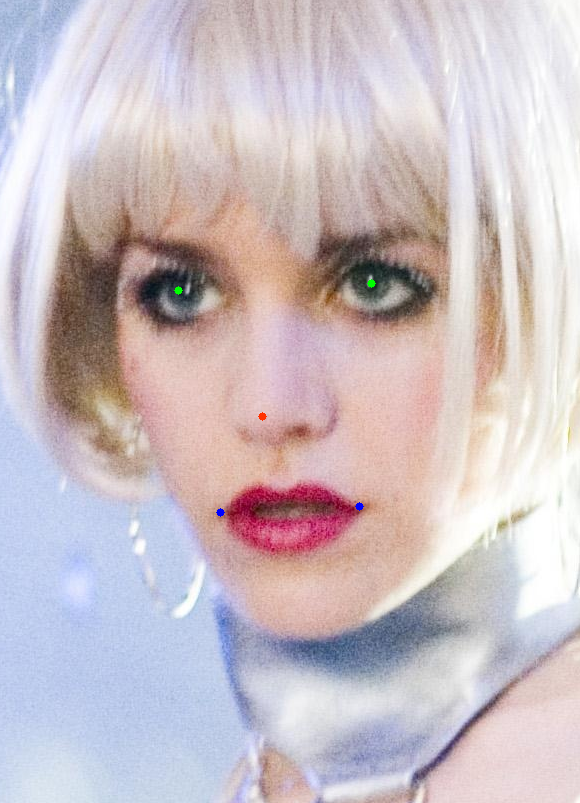

In [80]:
ix = 18280

def get_bbox_and_landmarks(ix, bbox=True, lm=True):
    face = df.iloc[ix]
    image_id = face['image_id']
    landmarks = None

    # img
    image = cv2.imread(f'/content/filtered/{image_id}')

    # bbox
    if bbox:
        x, y, w, h = face[['x_1', 'y_1', 'width', 'height']].values
        if bbox == 'crop':
            image = image[y:y + h,
                          x:x + w]
        else:
            cv2.rectangle(image,
                          pt1=(x, y), pt2=(x + w, y + h),
                          color=(0, 0, 255),
                          thickness=3)

    # landmarks
    if lm:
        landmarks = batched(face[[
            'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y',
            'nose_x', 'nose_y',
            'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y'
            ]].values, 2)
        if bbox == 'crop':
            landmarks = [(x_ - x, y_ - y) for (x_, y_) in landmarks]

    return image, landmarks, image_id

def draw_landmarks(image, landmarks):
    new_image = image.copy()
    colors = {'eye': (0, 255, 0),
              'nose': (0, 50, 255),
              'mouth': (255, 0, 0)}

    for lm, color in zip(landmarks,
                        'eye eye nose mouth mouth'.split()):
        cv2.circle(new_image,
                  center=lm,
                  radius=1,
                  color=colors[color],
                  thickness=5)
    return new_image

image, landmarks, image_id = get_bbox_and_landmarks(ix, bbox='crop')
cv2_imshow(draw_landmarks(image, landmarks))

Далее необходимо обрезать отфильтрованные изображения по координатам ббокса лица.

In [81]:
# создать директорию
cropped_folder_path = 'cropped'
os.makedirs(cropped_folder_path, exist_ok=True)

# создать датафрейм с именем и ключевыми точками обрезанных изображений
cropped_cols = ('image_id', 'identity',
                'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y',
                'nose_x', 'nose_y',
                'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y')
cropped_df = pd.DataFrame(columns=cropped_cols)

for ix in tnrange(len(df), desc='Cropping images'):
    # обрезать изображение по ббоксу, взять новые ключевые точки и метку класса
    image, landmarks, image_id = get_bbox_and_landmarks(ix, bbox='crop')
    identity = int(df.iloc[ix].identity)

    # положить строкой в новый датафрейм
    row = [image_id, identity] + [int(j) for i in landmarks for j in i]
    cropped_df.loc[ix] = row

    # сохранить обрезанное изображение в директорию
    cv2.imwrite(os.path.join(cropped_folder_path, image_id), image)

Cropping images:   0%|          | 0/20000 [00:00<?, ?it/s]

In [82]:
# атрибуты более не требуются; только название, класс и координаты ключевых точек
cropped_df

image_id  identity  lefteye_x  lefteye_y  righteye_x  righteye_y  \
0      000007.jpg      9040         65        105         140          97   
1      000018.jpg      2464         60         97         144         103   
2      000024.jpg      9290         35         57          80          89   
3      000051.jpg      1446         78        127         182         133   
4      000052.jpg      3896        102        166         213         131   
...           ...       ...        ...        ...         ...         ...   
19995  202548.jpg      7095         39         64          85          63   
19996  202559.jpg      5768         74        120         170         133   
19997  202560.jpg      6494         57         92         127          73   
19998  202561.jpg      8787         63        103         143         104   
19999  202581.jpg      7902         60         97         143          98   

       nose_x  nose_y  leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0          99     149           76          184           138           178  
1          98     144           57          172           137           177  
2          45      82           13          101            48           130  
3         112     197           75          214           168           231  
4         169     224          147          291           245           259  
...       ...     ...          ...          ...           ...           ...  
19995      62      83           45          112            82           112  
19996     111     193           66          212           164           224  
19997     107     130           80          161           141           144  
19998     100     150           53          182           150           183  
19999     101     137           63          171           134           173  

[20000 rows x 12 columns]

In [85]:
# сохранить csv-файл с метаданными обрезанных изображений
cropped_df.to_csv('celeba_filtered_cropped.csv', index=False)
cropped_df.to_csv('/content/drive/MyDrive/DLS/FR/celeba_filtered_cropped.csv', index=False)

In [ ]:
# 1 минута
!zip -rq cropped.zip cropped

In [87]:
# копировать файлы на GDrive
source = "/content/cropped.zip"
destination = "/content/drive/MyDrive/DLS/FR/cropped.zip"

shutil.copy(source, destination)

'/content/drive/MyDrive/DLS/FR/cropped.zip'

# Архитектура StackedHourglass

Архитектура по умолчанию предполагает 4 модуля, 2 стека, на вход ожидает изображения 256x256 и возвращает тепловые карты размером 64x64. Ап- и даунсэмплинг реализованы посредством необучаемых слоев в целях повышения скорости инференса.

In [7]:
class ResidualBlock(nn.Module):
    """Базовый residual блок из Stacked Hourglass.

    Следует архитектуре:
    conv1x1 → conv3x3 → conv1x1 + skip connection
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Skip connection: identity или 1x1 conv для согласования каналов
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)


class Hourglass(nn.Module):
    """Один модуль 'песочных часов' глубины n.
    При ап/даунсэмплинге используются необучаемые слои (для скорости).

    Args:
        n: глубина рекурсии (количество уровней даунсэмпла)
        f: количество фильтров на всех уровнях
    """
    def __init__(self, n, f, residual_block):
        super().__init__()
        assert n >= 1, "Глубина hourglass должна быть >= 1"

        self.up1 = residual_block(f, f)
        self.pool = nn.MaxPool2d(2, 2)

        if n == 1:
            # Базовый случай: два residual блока на самом нижнем уровне
            self.low1 = residual_block(f, f)
            self.low2 = residual_block(f, f)
        else:
            # Рекурсивный вызов для более глубокой структуры
            self.low1 = Hourglass(n - 1, f, residual_block)

        self.low3 = residual_block(f, f)
        # Апсэмпл: nearest neighbour достаточно для этой задачи
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        up1 = self.up1(x)          # Обработка на текущем разрешении
        low1 = self.pool(x)        # Даунсэмпл
        low2 = self.low1(low1)     # Рекурсивная обработка
        low3 = self.low3(low2)     # Обработка после рекурсии
        up2 = self.up2(low3)       # Апсэмпл обратно
        return up1 + up2           # Skip connection


class StackedHourglassNetwork(nn.Module):
    """Stacked Hourglass Network для предсказания ключевых точек.

    Выход: [B, n_stacks, n_landmarks, H/4, W/4]
    где H, W — размер входного изображения.
    """
    def __init__(self, n_stacks=2, n_modules=4, n_landmarks=5, in_channels=3):
        super().__init__()
        self.n_stacks = n_stacks
        self.n_landmarks = n_landmarks

        # Начальный блок: уменьшает разрешение до H/4, W/4
        self.pre = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),  # /2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2, 2),  # /2 → итого /4
            ResidualBlock(128, 128),
            ResidualBlock(128, 256)
        )

        # Инициализация стеков
        hg_modules, res_modules, fc_modules, score_modules = [], [], [], []
        for i in range(n_stacks):
            hg_modules.append(Hourglass(n_modules, 256, ResidualBlock))
            res_modules.append(ResidualBlock(256, 256))
            fc_modules.append(nn.Sequential(
                nn.Conv2d(256, 256, 1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            ))
            score_modules.append(nn.Conv2d(256, n_landmarks, 1))

        self.hg = nn.ModuleList(hg_modules)
        self.res = nn.ModuleList(res_modules)
        self.fc = nn.ModuleList(fc_modules)
        self.score = nn.ModuleList(score_modules)

        # Модули для промежуточной обратной связи (между стеками)
        self.fc_ = nn.ModuleList([nn.Conv2d(256, 256, 1) for _ in range(n_stacks - 1)])
        self.score_ = nn.ModuleList([nn.Conv2d(n_landmarks, 256, 1) for _ in range(n_stacks - 1)])

    def forward(self, x):
        x = self.pre(x)  # [B, 256, H/4, W/4]
        combined_hm_preds = []

        for i in range(self.n_stacks):
            hg = self.hg[i](x)
            hg = self.res[i](hg)
            hg = self.fc[i](hg)
            score = self.score[i](hg)
            combined_hm_preds.append(score)

            # Промежуточная обратная связь (кроме последнего стека)
            if i < self.n_stacks - 1:
                x = x + self.fc_[i](hg) + self.score_[i](score)

        return torch.stack(combined_hm_preds, dim=1)  # [B, n_stacks, n_landmarks, H/4, W/4]

# Подготовка датасета для подачи на вход модели

### Cropped images and landmarks

In [9]:
# ~ 1 minute
# загрузка и распаковка обрезанных изображений
!gdown 1Ci0vB5ltOaNBcp07-siJp4v1qUDAhtqq
!unzip -q cropped.zip
!rm cropped.zip

# загрузка ключевых точек (`celeba_filtered_cropped.csv`)
!gdown 1rdonX7TkLWwYs2YmJUsw9ABJ8dIY_GXh

Downloading...
From (original): https://drive.google.com/uc?id=1Ci0vB5ltOaNBcp07-siJp4v1qUDAhtqq
From (redirected): https://drive.google.com/uc?id=1Ci0vB5ltOaNBcp07-siJp4v1qUDAhtqq&confirm=t&uuid=1c97f067-3741-4908-9ce2-1a8a3a9362af
To: /content/cropped.zip
100% 1.50G/1.50G [00:22<00:00, 67.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rdonX7TkLWwYs2YmJUsw9ABJ8dIY_GXh
To: /content/celeba_filtered_cropped.csv
100% 1.03M/1.03M [00:00<00:00, 11.0MB/s]


In [27]:
df = pd.read_csv('/content/celeba_filtered_cropped.csv')
df

image_id  identity  lefteye_x  lefteye_y  righteye_x  righteye_y  \
0      000007.jpg      9040         65        105         140          97   
1      000018.jpg      2464         60         97         144         103   
2      000024.jpg      9290         35         57          80          89   
3      000051.jpg      1446         78        127         182         133   
4      000052.jpg      3896        102        166         213         131   
...           ...       ...        ...        ...         ...         ...   
19995  202548.jpg      7095         39         64          85          63   
19996  202559.jpg      5768         74        120         170         133   
19997  202560.jpg      6494         57         92         127          73   
19998  202561.jpg      8787         63        103         143         104   
19999  202581.jpg      7902         60         97         143          98   

       nose_x  nose_y  leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0          99     149           76          184           138           178  
1          98     144           57          172           137           177  
2          45      82           13          101            48           130  
3         112     197           75          214           168           231  
4         169     224          147          291           245           259  
...       ...     ...          ...          ...           ...           ...  
19995      62      83           45          112            82           112  
19996     111     193           66          212           164           224  
19997     107     130           80          161           141           144  
19998     100     150           53          182           150           183  
19999     101     137           63          171           134           173  

[20000 rows x 12 columns]

## Служебные функции

In [28]:
def clear_memory():
    """Очистка кэша ускорителя"""
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
        gc.collect()

def get_image_and_landmarks(ix):
    """
    Извлекает BGR-массив изображения, координатные пары лендмарков и метку класса для объекта по индексу (iloc) в наборе
    """
    image_id, identity, *landmarks = df.iloc[ix]
    image = cv2.imread(f'cropped/{image_id}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image, [*batched(map(int, landmarks), 2)], int(identity)

def landmarks_to_heatmaps_torch(landmarks, image_size, sigma=2.0):
    """
    Генерирует тепловые карты из лендмарков на GPU/TPU.

    Args:
        landmarks: тензор [B, N, 2] в формате (x, y)
        image_size: tuple (H, W)
        sigma: float

    Returns:
        heatmaps: тензор [B, N, H, W]
    """
    B, N, _ = landmarks.shape
    H, W = image_size

    # Создаём координатные сетки
    y = torch.arange(H, device=landmarks.device, dtype=torch.float32)
    x = torch.arange(W, device=landmarks.device, dtype=torch.float32)
    yy, xx = torch.meshgrid(y, x, indexing='ij')  # [H, W]

    # Расширяем до [B, N, H, W]
    xx = xx.unsqueeze(0).unsqueeze(0).expand(B, N, -1, -1)
    yy = yy.unsqueeze(0).unsqueeze(0).expand(B, N, -1, -1)

    # Координаты точек: [B, N, 1, 1]
    lx = landmarks[:, :, 0].view(B, N, 1, 1)
    ly = landmarks[:, :, 1].view(B, N, 1, 1)

    # Гауссиан
    heatmaps = torch.exp(-((xx - lx)**2 + (yy - ly)**2) / (2 * sigma**2))
    return heatmaps

def resize_with_pad_and_update_landmarks(image, landmarks, target_size=256, mirror=False):
    """
    Ресайзит изображение до максимальной вписываемой области в target_size×target_size,
    добавляет паддинг, обновляет координаты лендмарков.

    Args:
        image: np.ndarray [H, W, C]
        landmarks: list of (x, y)
        target_size: int

    Returns:
        resized_image: [target_size, target_size, C]
        new_landmarks: list of (x, y) in new coordinates
    """
    h, w = image.shape[:2]

    # Масштаб для вписывания
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    # Ресайз
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Обновляем лендмарки
    new_landmarks = [(x * scale, y * scale) for (x, y) in landmarks]

    # Паддинг до квадрата
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    pad_top = pad_h // 2
    pad_left = pad_w // 2

    border_padding = dict(borderType=cv2.BORDER_CONSTANT,
                          value=(127, 127, 127))
    if mirror:
        border_padding = dict(borderType=cv2.BORDER_REFLECT_101)

    padded = cv2.copyMakeBorder(
        resized, pad_top, pad_h - pad_top, pad_left, pad_w - pad_left,
        **border_padding
        )

    # Сдвигаем лендмарки из-за паддинга
    new_landmarks = [(x + pad_left, y + pad_top) for (x, y) in new_landmarks]

    return padded, new_landmarks


def apply_augmentations(image, landmarks, target_size=256, mirror=False):
    """
    Применяет аугментации к изображению и корректирует лендмарки.

    Args:
        image: np.ndarray [H, W, 3] (RGB)
        landmarks: list of (x, y)
        target_size: int

    Returns:
        aug_image: np.ndarray [target_size, target_size, 3]
        aug_landmarks: list of (x, y)
    """
    h, w = image.shape[:2]

    # 1. Horizontal Flip (с вероятностью 50%)
    if rn.random() > 0.5:
        image = np.fliplr(image).copy()
        # Переставляем точки: [левый глаз, правый глаз, нос, левый угол рта, правый угол рта]
        landmarks = [
            (w - landmarks[1][0], landmarks[1][1]),  # правый глаз → левый
            (w - landmarks[0][0], landmarks[0][1]),  # левый глаз → правый
            (w - landmarks[2][0], landmarks[2][1]),  # нос
            (w - landmarks[4][0], landmarks[4][1]),  # правый угол рта → левый
            (w - landmarks[3][0], landmarks[3][1])   # левый угол рта → правый
        ]
        # Обновляем ширину для следующих операций
        w = image.shape[1]

    # 2. Небольшой поворот (±10 градусов)
    angle = rn.uniform(-10, 10)
    if abs(angle) > 0.1:
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        border_padding = dict(borderMode=cv2.BORDER_CONSTANT,
                          borderValue=(127, 127, 127))
        if mirror:
            border_padding = dict(borderMode=cv2.BORDER_REFLECT_101)

        image = cv2.warpAffine(
            image, M, (w, h),
            flags=cv2.INTER_LINEAR,
            **border_padding
        )
        # Поворачиваем лендмарки
        new_landmarks = []
        for (x, y) in landmarks:
            pt = np.array([x, y, 1.0])
            new_pt = M @ pt
            new_landmarks.append((new_pt[0], new_pt[1]))
        landmarks = new_landmarks

    # 3. Color Jitter (яркость, контраст, насыщенность)
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    jitter = T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
    image_tensor = jitter(image_tensor)
    image = (image_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    # 4. Приводим к финальному размеру (256×256)
    image, landmarks = resize_with_pad_and_update_landmarks(image, landmarks, target_size)

    return image, landmarks

## Datasets/Dataloaders

In [12]:
class FaceLandmarkDataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_dir: str, target_size: int = 256, augment: bool = True):
        """
        Args:
            df: датафрейм с индексами, названием и разметкой (напр., `celeba_filtered_cropped.csv`)
            img_dir: путь к папке с изображениями (напр., `cropped/`)
            target_size: целевой размер изображения (256)
            augment: включить аугментацию (True/False)
        """
        self.df = df
        self.img_dir = img_dir
        self.target_size = target_size
        self.augment = augment

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # Извлекаем данные
        row = self.df.iloc[idx]
        image_id = row['image_id']

        # Ожидаем, что в CSV 10 колонок: image_id, identity, x1,y1,x2,y2,...,x5,y5
        landmarks_raw = row[2:12].values.astype(float)  # последние 10 значений
        landmarks = [(landmarks_raw[i], landmarks_raw[i+1]) for i in range(0, 10, 2)]

        # Загружаем изображение
        image = cv2.imread(os.path.join(self.img_dir, image_id))

        # Конвертируем BGR → RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Приводим к 256×256 с паддингом и обновляем лендмарки (с аугментацией или без нее)
        if self.augment:
            image, landmarks = apply_augmentations(image, landmarks, self.target_size)
        else:
            image, landmarks = resize_with_pad_and_update_landmarks(image, landmarks, self.target_size, mirror=False)

        # Преобразуем в тензоры
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float()  # [C, H, W]
        landmarks_tensor = torch.tensor(landmarks, dtype=torch.float32)   # [5, 2]

        return image_tensor, landmarks_tensor

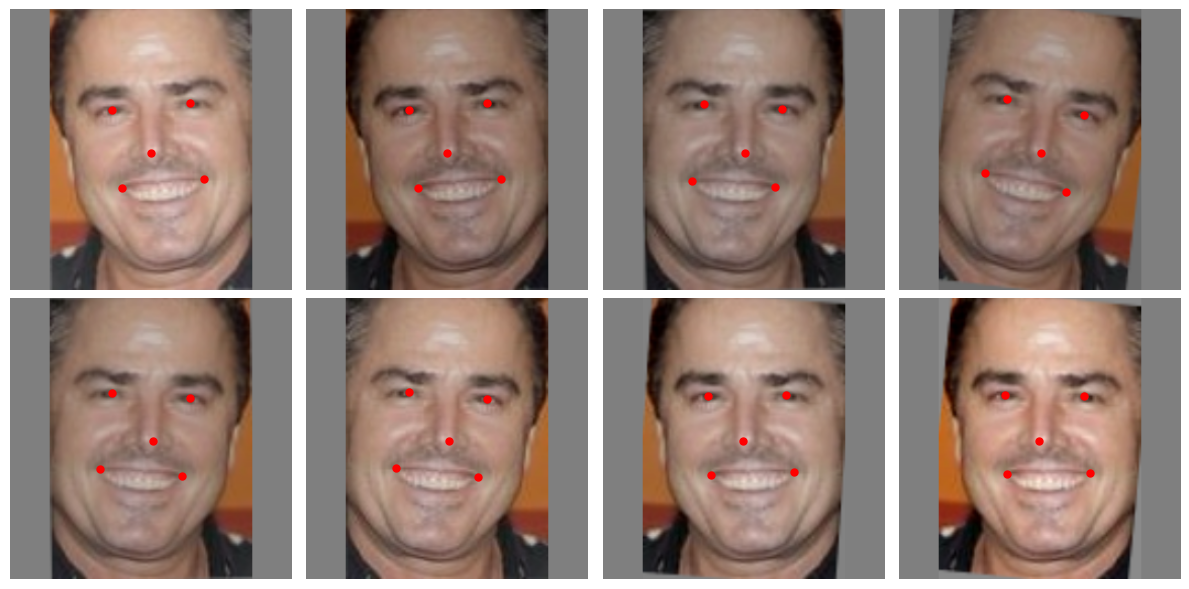

In [30]:
# Создаём датасет с аугментациями
dataset_aug = FaceLandmarkDataset(
    df = df,
    img_dir='cropped',
    augment=True)

# Визуализируем несколько примеров
ix = 1991

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    img, lm = dataset_aug[ix]  # каждый вызов даёт новую аугментацию
    ax = axes[i//4, i%4]
    ax.imshow(img.permute(1, 2, 0).byte())
    for x, y in lm:
        ax.plot(x, y, 'ro', markersize=5)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# создание датафреймов (0.8/0.2)
train_df = df.sample(frac=.8, random_state=42)
test_df = df.drop(index=train_df.index)

img_dir = 'cropped'
# все файлы в одной директории
train_dir = val_dir = img_dir

# Создаём датасет (с аугментациями для train, без — для val/test)
train_dataset = FaceLandmarkDataset(
    df=train_df,
    img_dir=train_dir,
    augment=True)

val_dataset = FaceLandmarkDataset(
    df=test_df,
    img_dir=val_dir,
    augment=False)

# Training

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Функции для цикла обучения и служебные функции

In [16]:
def heatmaps_to_landmarks(heatmaps):
    """
    Преобразует heatmap'ы в координаты ключевых точек.

    Args:
        heatmaps: torch.Tensor [B, 5, H, W]

    Returns:
        landmarks: torch.Tensor [B, 5, 2] в формате (x, y)
    """
    B, N, H, W = heatmaps.shape

    # Находим argmax по пространственным измерениям
    heatmaps_flat = heatmaps.view(B, N, -1)  # [B, N, H*W]
    max_indices = heatmaps_flat.argmax(dim=2)  # [B, N]

    # Преобразуем линейные индексы в (y, x)
    y_coords = max_indices // W
    x_coords = max_indices % W

    # Собираем в тензор [B, 5, 2]
    landmarks = torch.stack([x_coords, y_coords], dim=2).float()  # (x, y)

    return landmarks


def calculate_nme(pred_landmarks, gt_landmarks):
    """
    Вычисляет Normalized Mean Error (NME).

    Args:
        pred_landmarks: torch.Tensor [B, 5, 2] - предсказанные координаты (x, y)
        gt_landmarks: torch.Tensor [B, 5, 2] - ground truth координаты (x, y)

    Returns:
        nme: float - средний NME по батчу (%)
    """
    # Расстояние между каждой парой точек [B, 5]
    distances = torch.norm(pred_landmarks - gt_landmarks, dim=2)  # L2 norm

    # Межзрачковое расстояние (между точками 0 и 1)
    left_eye = gt_landmarks[:, 0]   # [B, 2]
    right_eye = gt_landmarks[:, 1]  # [B, 2]
    ipd = torch.norm(right_eye - left_eye, dim=1, keepdim=True)  # [B, 1]

    # Нормализованные ошибки [B, 5]
    normalized_errors = distances / ipd  # broadcasting

    # Средний NME по всем точкам и батчу
    nme = normalized_errors.mean().item() * 100  # в процентах

    return nme


def collate_fn(batch):
    """
    Преобразует батч [(image, landmarks), ...] в (images, heatmaps)

    Args:
        batch: list of tuples (image_tensor [3,256,256], landmarks_tensor [5,2])

    Returns:
        images: torch.Tensor [B, 3, 256, 256]
        heatmaps: torch.Tensor [B, 5, 64, 64]
    """
    images = torch.stack([item[0] for item in batch])      # [B, 3, 256, 256]
    landmarks_256 = torch.stack([item[1] for item in batch])  # [B, 5, 2]

    # Масштабируем лендмарки под heatmap resolution (64x64)
    landmarks_hm = landmarks_256 / 4.0  # [B, 5, 2]

    # Генерируем тепловые карты (на CPU)
    heatmaps = landmarks_to_heatmaps_torch(
        landmarks_hm,
        image_size=(64, 64),
        sigma=2.0
    )  # [B, 5, 64, 64]

    return images, heatmaps

In [119]:
def fit_one_epoch(model, train_loader, criterion, optimizer, scheduler, device, scaler):
    model.train()
    n_stacks = model.n_stacks
    num_batches = len(train_loader)
    epoch_loss = 0.0
    epoch_nme = 0.0

    for images, gt_heatmaps in tqdm(train_loader, desc='Train', leave=False):
        optimizer.zero_grad()

        images = images.to(device)
        gt_heatmaps = gt_heatmaps.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images) # outputs — [B, S, 5, 64, 64], S heatmaps от разных голов

            batch_loss = 0.0
            for stack in range(n_stacks):
                batch_loss += criterion(outputs[:, stack], gt_heatmaps) # gt_heatmaps — [B, 5, 64, 64]
        scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += batch_loss.item()

        # расчет NME: преобразуем тепловые карты в координаты
        pred_landmarks = heatmaps_to_landmarks(outputs[:, -1])  # [B, 5, 2]
        gt_landmarks = heatmaps_to_landmarks(gt_heatmaps)       # [B, 5, 2]
        batch_nme = calculate_nme(pred_landmarks, gt_landmarks)
        epoch_nme += batch_nme

    avg_loss = epoch_loss / num_batches
    avg_nme = epoch_nme / num_batches

    if scheduler:
        if type(scheduler).__name__ == 'ReduceLROnPlateau':
            scheduler.step(avg_nme)
        else:
            scheduler.step()

    return avg_loss, avg_nme

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    n_stacks = model.n_stacks
    num_batches = len(val_loader)
    epoch_loss = 0.0
    epoch_nme = 0.0

    with torch.no_grad():
        for images, gt_heatmaps in tqdm(val_loader, desc='Validate', leave=False):
            images = images.to(device)
            gt_heatmaps = gt_heatmaps.to(device)

            outputs = model(images)  # [B, S, 5, 64, 64]

            batch_loss = 0.0
            for stack in range(n_stacks):
                batch_loss += criterion(outputs[:, stack], gt_heatmaps)
            epoch_loss += batch_loss.item()

            # расчет NME
            pred_landmarks = heatmaps_to_landmarks(outputs[:, -1])  # [B, 5, 2]
            gt_landmarks = heatmaps_to_landmarks(gt_heatmaps)       # [B, 5, 2]

            batch_nme = calculate_nme(pred_landmarks, gt_landmarks)
            epoch_nme += batch_nme

    avg_loss = epoch_loss / num_batches
    avg_nme = epoch_nme / num_batches

    return avg_loss, avg_nme

def train(model, train_loader, val_loader, n_epochs,
          criterion, optimizer, scheduler, device):
    model.to(device)
    scaler = torch.amp.GradScaler()
    history = {
        'train_loss': [], 'val_loss': [],
        'train_nme': [], 'val_nme': []
    }
    checkpoint = None
    best_nme_val = float('inf')

    try:
        for epoch in tnrange(n_epochs, desc='Epochs'):
            epoch_loss_train, epoch_nme_train = fit_one_epoch(
                model, train_loader, criterion, optimizer, scheduler, device, scaler)
            epoch_loss_val, epoch_nme_val = validate_one_epoch(
                model, val_loader, criterion, device)
            print(f'Epoch {epoch + 1}:',
                  f'Train_loss={epoch_loss_train:.4f} | Val_loss={epoch_loss_val:.4f}',
                  f'| Train_NME={epoch_nme_train:.2f}% | Val_NME={epoch_nme_val:.2f}%')

            history['train_loss'].append(epoch_loss_train)
            history['val_loss'].append(epoch_loss_val)
            history['train_nme'].append(epoch_nme_train)
            history['val_nme'].append(epoch_nme_val)

            # чекпоинт при улучшении val_NME
            if epoch_nme_val < best_nme_val:
                best_nme_val = epoch_nme_val
                checkpoint = {
                    'model_state_dict': model.state_dict().copy(),
                    'optimizer_state_dict': optimizer.state_dict().copy(),
                    'scaler_state_dict': scaler.state_dict().copy(),
                    'scheduler_state_dict': scheduler.state_dict().copy() if scheduler else None,
                    'history': history,
                    'epoch': epoch}
                torch.save(checkpoint, 'checkpoint.pth')
                print('Best model updated')

    except KeyboardInterrupt:
        clear_memory()
        print("\nInterrupted. Cache cleared. Current model saved.")
        # Сохраняем текущую модель
        torch.save({
            'model_state_dict': model.state_dict(),
            'history': history,
            'epoch': epoch
        }, 'interrupted_checkpoint.pth')
        return model, history

    # загрузка лучшей модели
    if checkpoint:
        finetuned_model = copy.copy(model)
        finetuned_model.load_state_dict(checkpoint['model_state_dict'])

    return finetuned_model, history

In [17]:
def visualize_predictions(model, dataset, device, num_samples=5, save_path=None):
    """
    Визуализирует истинные и предсказанные лендмарки на случайных изображениях.

    Args:
        model: обученная модель StackedHourglassNetwork
        dataset: датасет (train или val)
        device: устройство для inference
        num_samples: количество изображений для визуализации
        save_path: путь для сохранения изображения (опционально)
    """
    model.eval()

    # Выбираем случайные индексы
    indices = rn.sample(range(len(dataset)), min(num_samples, len(dataset)))

    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Получаем изображение и gt-лендмарки
            image_tensor, gt_landmarks_256 = dataset[idx]  # [3, 256, 256], [5, 2]

            # Подготовка для модели
            image_batch = image_tensor.unsqueeze(0).to(device)  # [1, 3, 256, 256]

            # Предсказание
            outputs = model(image_batch)  # [1, S, 5, 64, 64]
            pred_heatmaps = outputs[0, -1]  # [5, 64, 64]

            # Преобразуем тепловые карты в координаты (64x64 → 256x256)
            pred_landmarks_64 = heatmaps_to_landmarks(pred_heatmaps.unsqueeze(0))[0]  # [5, 2]
            pred_landmarks_256 = pred_landmarks_64 * 4.0  # масштабируем обратно к 256x256

            # Конвертируем тензоры в numpy для визуализации
            image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
            gt_landmarks_np = gt_landmarks_256.cpu().numpy()
            pred_landmarks_np = pred_landmarks_256.cpu().numpy()

            # Верхний ряд: ground truth
            axes[0, i].imshow(image_np.astype('uint8'))
            axes[0, i].scatter(gt_landmarks_np[:, 0], gt_landmarks_np[:, 1],
                             c='red', s=50, marker='o', label='GT')
            axes[0, i].set_title(f'Sample {idx}\nGround Truth')
            axes[0, i].axis('off')

            # Нижний ряд: предсказание
            axes[1, i].imshow(image_np.astype('uint8'))
            axes[1, i].scatter(pred_landmarks_np[:, 0], pred_landmarks_np[:, 1],
                             c='blue', s=50, marker='x', label='Pred', linewidths=3)
            axes[1, i].set_title('Prediction')
            axes[1, i].axis('off')

            # Добавляем легенду только для первого изображения
            if i == 0:
                axes[0, i].legend()
                axes[1, i].legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()

    # Опционально: вычисляем NME для этих образцов
    nme_sample = calculate_nme(
        torch.tensor(pred_landmarks_np).unsqueeze(0),
        torch.tensor(gt_landmarks_np).unsqueeze(0)
    )
    print(f"Sample NME: {nme_sample:.2f}%")

def predict_landmarks(model, image, device, resize=False, target_size=256):
    """
    Предсказывает ключевые точки лица на изображении произвольного размера.

    Args:
        model: обученная модель StackedHourglassNetwork
        image: np.ndarray [H, W, C] - исходное изображение в BGR или RGB
        device: устройство для inference ('cuda' или 'cpu')
        resize: bool - если True, возвращает преобразованное изображение 256x256 и лендмарки для него;
                если False, возвращает только лендмарки для исходного изображения
        target_size: int - целевой размер для нормализации (по умолчанию 256)

    Returns:
        Если resize=True: (resized_image, landmarks_256)
            resized_image: np.ndarray [256, 256, C]
            landmarks_256: np.ndarray [5, 2] - координаты в системе координат 256x256

        Если resize=False: landmarks_original
            landmarks_original: np.ndarray [5, 2] - координаты в системе координат исходного изображения
    """
    model.eval()

    # Сохраняем исходные размеры
    orig_h, orig_w = image.shape[:2]

    # Создаем фиктивные лендмарки для использования `resize_with_pad_and_update_landmarks`
    dummy_landmarks = [(0, 0)] * 5

    # Преобразуем изображение к 256x256 с паддингом
    resized_image, _ = resize_with_pad_and_update_landmarks(
        image, dummy_landmarks, target_size
    )

    # Конвертируем в тензор
    if len(resized_image.shape) == 3:
        image_tensor = torch.from_numpy(resized_image).permute(2, 0, 1).float()  # [C, H, W]
    else:
        image_tensor = torch.from_numpy(resized_image).unsqueeze(0).float()  # [1, H, W]

    # Добавляем batch dimension и переносим на устройство
    image_batch = image_tensor.unsqueeze(0).to(device)  # [1, C, 256, 256]

    with torch.no_grad():
        # Получаем предсказание
        outputs = model(image_batch)  # [1, S, 5, 64, 64]
        pred_heatmaps = outputs[0, -1]  # [5, 64, 64]

        # Преобразуем heatmap'ы в координаты (64x64)
        pred_landmarks_64 = heatmaps_to_landmarks(pred_heatmaps.unsqueeze(0))[0]  # [5, 2]

        # Масштабируем к 256x256
        pred_landmarks_256 = pred_landmarks_64 * 4.0  # [5, 2]

    # Конвертируем в numpy
    landmarks_256_np = pred_landmarks_256.cpu().numpy()

    if resize:
        # Возвращаем преобразованное изображение и лендмарки для 256x256
        return resized_image.astype(np.uint8), landmarks_256_np
    else:
        # Обратное преобразование координат в исходную систему координат

        # 1. Убираем паддинг из координат
        scale = target_size / max(orig_h, orig_w)
        new_w, new_h = int(orig_w * scale), int(orig_h * scale)
        pad_h = target_size - new_h
        pad_w = target_size - new_w
        pad_top = pad_h // 2
        pad_left = pad_w // 2

        landmarks_no_pad = landmarks_256_np - [pad_left, pad_top]

        # 2. Обратное масштабирование к исходному размеру
        landmarks_original = landmarks_no_pad / scale

        return landmarks_original

def draw_face_with_landmarks(image, landmarks):
    landmarks = np.array(landmarks)
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Input image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c='red', s=50)
    plt.title('Image with landmarks')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Цикл обучения

In [ ]:
batch_size = 32
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=collate_fn) # генерация тепловых карт (побатчевая, 64*64)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size * 2,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=collate_fn) # тепловые карты

In [ ]:
clear_memory()

In [ ]:
model = StackedHourglassNetwork(n_stacks=2, n_modules=4, n_landmarks=5).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, )

n_epochs = 7
model, history = train(model, train_loader, val_loader, n_epochs,
                       criterion, optimizer, scheduler, device)

Epochs:   0%|          | 0/7 [00:00<?, ?it/s]

Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validate:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1: Train_loss=0.0113 | Val_loss=0.0027 | Train_NME=67.40% | Val_NME=9.23%


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validate:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2: Train_loss=0.0013 | Val_loss=0.0007 | Train_NME=6.24% | Val_NME=4.38%


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validate:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3: Train_loss=0.0006 | Val_loss=0.0005 | Train_NME=4.41% | Val_NME=3.64%


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validate:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4: Train_loss=0.0005 | Val_loss=0.0004 | Train_NME=4.00% | Val_NME=3.18%


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validate:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5: Train_loss=0.0004 | Val_loss=0.0004 | Train_NME=3.67% | Val_NME=3.15%


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validate:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6: Train_loss=0.0003 | Val_loss=0.0004 | Train_NME=3.53% | Val_NME=3.07%


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validate:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7: Train_loss=0.0003 | Val_loss=0.0004 | Train_NME=3.43% | Val_NME=3.24%


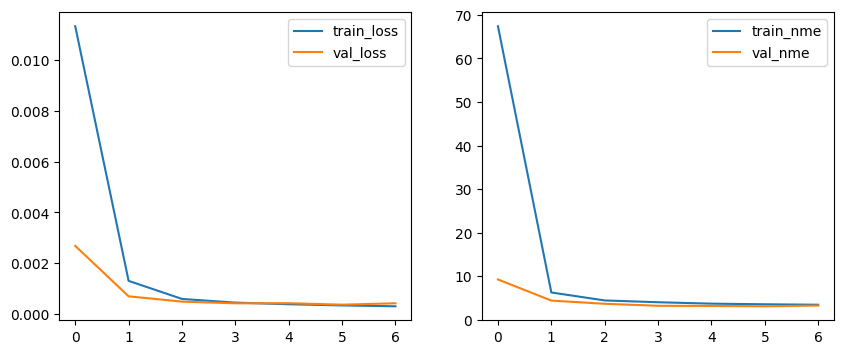

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

for i, (k, v) in enumerate(history.items()):
    ax[i // 2].plot(v, label=k)
    ax[i // 2].legend()
    ax[i // 2].grid()
fig.show()

# Загрузка обученной модели

In [18]:
def load_best_model(checkpoint_path, model_class, device, **model_kwargs):
    """
    Загружает лучшую модель из чекпоинта.

    Args:
        checkpoint_path: путь к файлу чекпоинта
        model_class: класс модели (например, StackedHourglassNetwork)
        device: устройство ('cuda' или 'cpu')
        **model_kwargs: аргументы для инициализации модели (n_stacks, n_modules, etc.)

    Returns:
        model: модель с загруженными весами
        history: история обучения (если сохранена)
    """
    # Загружаем чекпоинт
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Инициализируем модель
    model = model_class(**model_kwargs).to(device)

    # Загружаем веса
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Получаем историю (если есть)
    history = checkpoint.get('history', None)

    print(f"Лучшая модель загружена! Epoch: {checkpoint['epoch'] + 1}")
    print(f"Val NME: {min(checkpoint['history']['val_nme']):.4f}%")

    return model, history

In [19]:
# загрузка чекпоинта с моделью
!gdown 1Lp_VeiExd5EO4DlF-GIYDTdBVBHZzrQE

Downloading...
From (original): https://drive.google.com/uc?id=1Lp_VeiExd5EO4DlF-GIYDTdBVBHZzrQE
From (redirected): https://drive.google.com/uc?id=1Lp_VeiExd5EO4DlF-GIYDTdBVBHZzrQE&confirm=t&uuid=d812174d-cd52-4e7a-bc79-43b84ffd47b9
To: /content/checkpoint.pth
100% 60.4M/60.4M [00:01<00:00, 35.4MB/s]


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
model_loaded, history_loaded = load_best_model(
    checkpoint_path='checkpoint.pth',
    model_class=StackedHourglassNetwork,
    device=device,
    n_stacks=2,
    n_modules=4,
    n_landmarks=5
)

Лучшая модель загружена! Epoch: 6
Val NME: 3.0709%


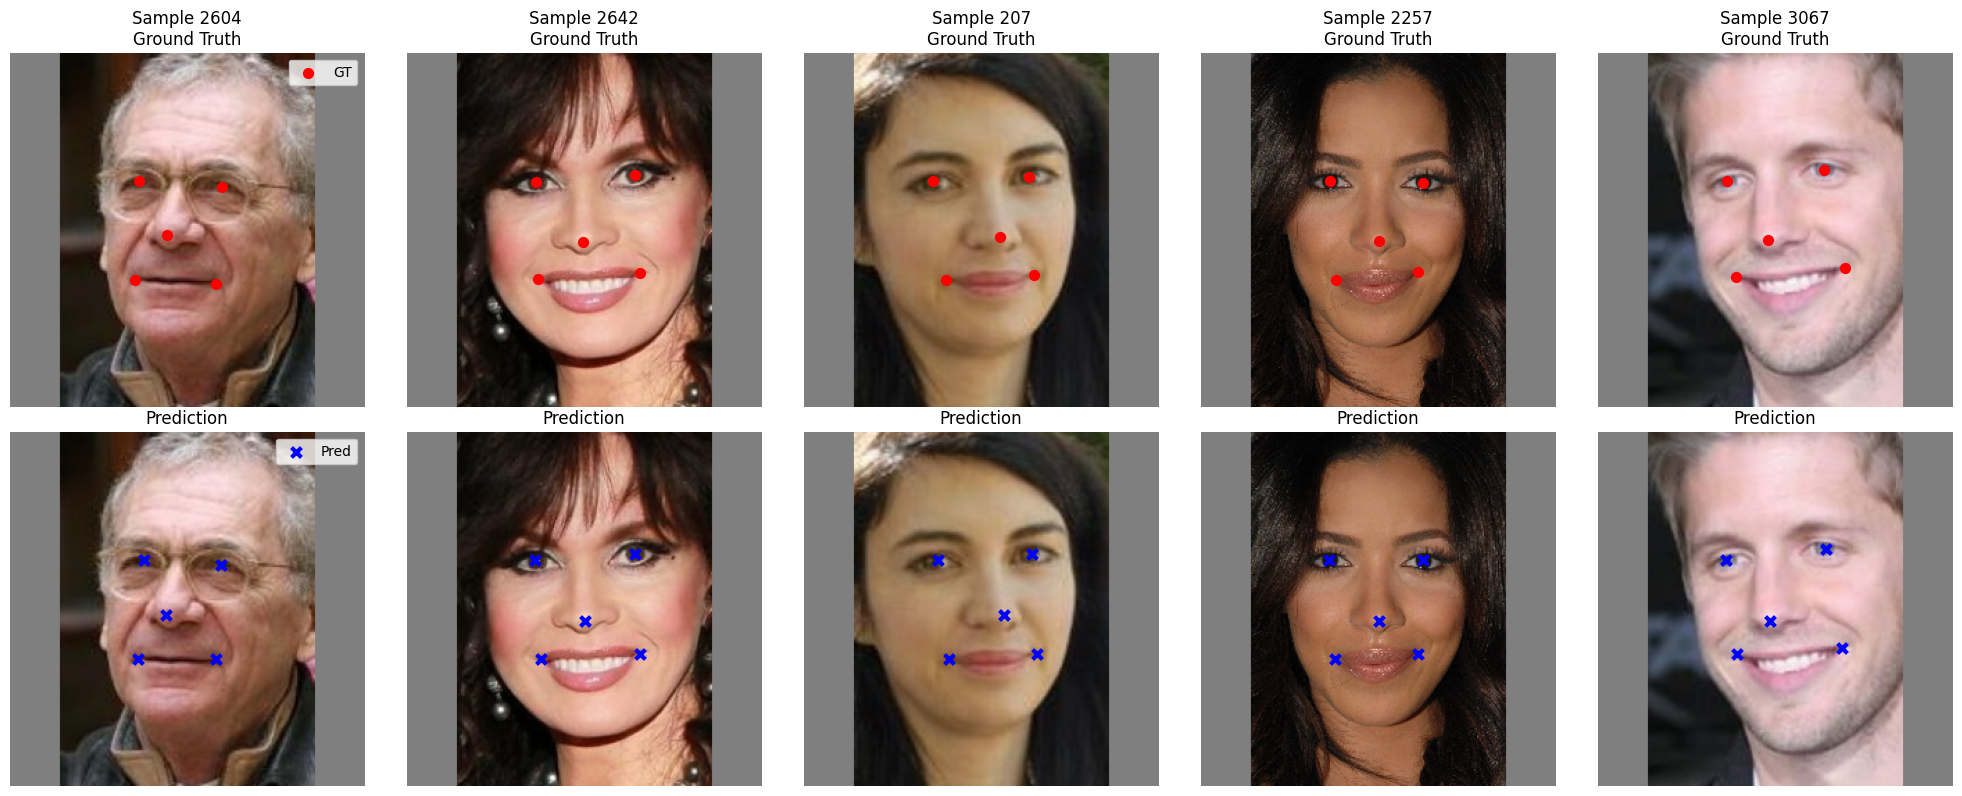

Sample NME: 2.39%


In [23]:
visualize_predictions(model_loaded, val_dataset, device)

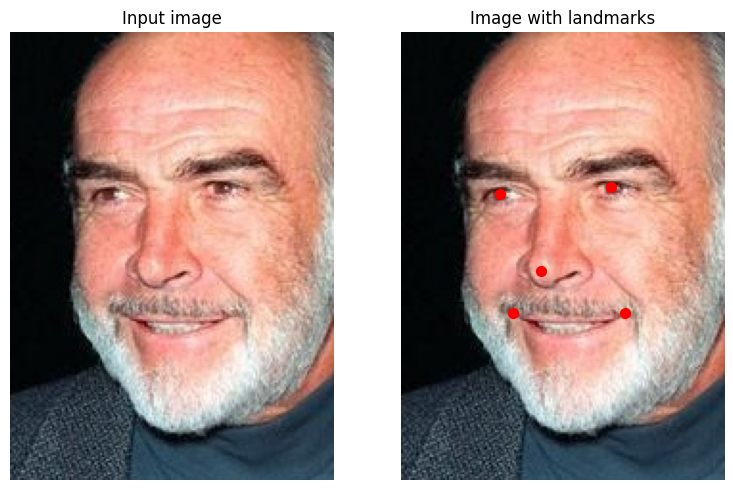

In [40]:
ix = 15010

image_folder = 'cropped'
image_name = os.listdir(image_folder)[ix]
image_path = os.path.join(image_folder, image_name)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Получить лендмарки для исходного изображения и отрисовать
landmarks = predict_landmarks(model_loaded, image, device, resize=False)

draw_face_with_landmarks(image, landmarks)

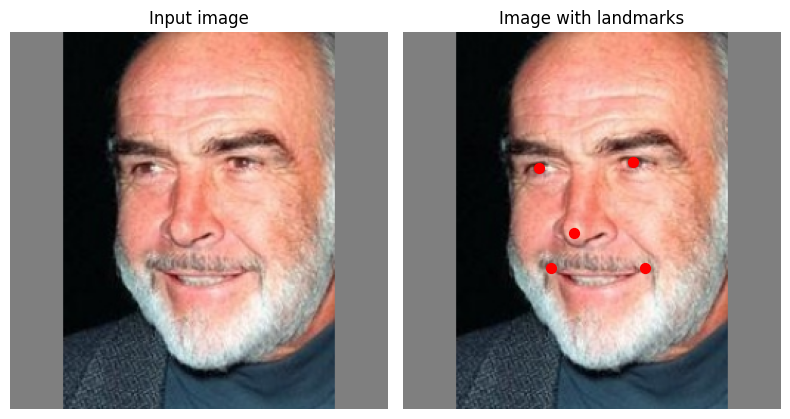

In [124]:
# Преобразованное изображение 256x256 и лендмарки для него
resized_image, landmarks_256 = predict_landmarks(model_loaded, image, device, resize=True)

draw_face_with_landmarks(resized_image, landmarks_256)

# Выравнивание по предсказанным точкам

Для выравнивания использовано афинное преобразование `warpAffine` библиотеки OpenCV.

Выравнивание проводится по трем ключевым точкам из предсказанных 5: **глаза** приводятся к горизонтальной линии, изображение центрируется вокруг **кончика носа**.

Возможны два варианта паддинга: зеркальный и константный серый (127, 127, 127); по умолчанию используется константный серый, т.к. ниже вероятность получить при обработке артефакт, напоминающий часть лицевого черепа.

In [25]:
def align_face_after_resize(image_256, landmarks_256, output_size=256, mirror=False):
    """Выполняет аффинное выравнивание на изображении 256×256."""
    le_x, le_y = landmarks_256[0]
    re_x, re_y = landmarks_256[1]
    nose_x, nose_y = landmarks_256[2]

    angle = np.degrees(np.arctan2(re_y - le_y, re_x - le_x))
    M = cv2.getRotationMatrix2D((nose_x, nose_y), angle, 1.0)
    M[0, 2] += output_size // 2 - nose_x
    M[1, 2] += output_size // 2 - nose_y

    # константный или зеркальный паддинг. по умолчанию используется константный
    border_padding = dict(borderMode=cv2.BORDER_CONSTANT,
                          borderValue=(127, 127, 127))
    if mirror:
        border_padding = dict(borderMode=cv2.BORDER_REFLECT_101)

    return cv2.warpAffine(
        image_256, M, (output_size, output_size),
        flags=cv2.INTER_LINEAR,
        **border_padding
    )

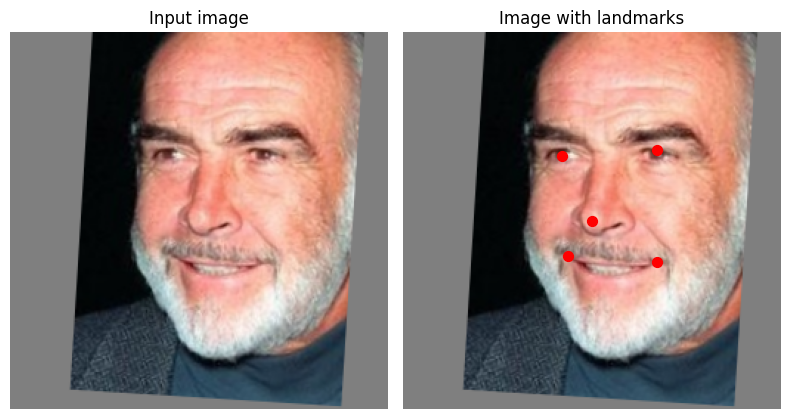

In [43]:
image_256, landmarks_256 = resize_with_pad_and_update_landmarks(image, landmarks)
aligned_image = align_face_after_resize(image_256, landmarks_256)
aligned_landmarks = predict_landmarks(model_loaded, aligned_image, device)

draw_face_with_landmarks(aligned_image, aligned_landmarks)

In [30]:
aligned_df = df.iloc[:, :2].copy()
aligned_df.to_csv('aligned.csv', index=False)

aligned_folder = 'aligned_pred'
shutil.rmtree(aligned_folder, ignore_errors=True)
os.makedirs(aligned_folder, exist_ok=True)

for ix in tnrange(len(df), desc='Aligning cropped images by predicted landmarks'):
    image_id, identity = aligned_df.iloc[ix]

    image = cv2.imread(f'/content/cropped/{image_id}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Получить лендмарки для исходного изображения
    landmarks = predict_landmarks(model_loaded, image, device, resize=False)

    # Привести к единому размеру и выровнять
    image_256, landmarks_256 = resize_with_pad_and_update_landmarks(image, landmarks, target_size=256, mirror=False)
    aligned_image = align_face_after_resize(image_256, landmarks_256, mirror=False)

    # записать в файл под тем же именем в разбивке по классам
    os.makedirs(
        os.path.join(aligned_folder,
                     str(identity)),
        exist_ok=True)
    cv2.imwrite(os.path.join(aligned_folder,
                             str(identity),
                             image_id),
                cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))


Aligning cropped images by predicted landmarks:   0%|          | 0/20000 [00:00<?, ?it/s]

In [31]:
# итоговый архив: 342 мб
!zip -rq aligned_pred.zip aligned_pred

In [11]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
source = "/content/aligned_pred.zip"
destination = "/content/drive/MyDrive/DLS/FR/aligned_pred.zip"

shutil.copy(source, destination)

# Результаты

Были поставлены задачи:
*   Подготовить датасет, сохранить файл с оригинальными названиями изображений
*   Реализовать Hourglass блок
*   Реализовать Stacked Hourglass
*   Преобразовать точки лица в Heatmap'ы
*   Обучить Stacked Hourglass
*   Найти функцию, которая по предсказанным ключевым точкам выравнивает лица на картинке (face alignment)
*   Подготовить датасет с кропнутыми и выровненными лицами для следующего этапа

Поставленные задачи успешно выполнены со следующими результатами:
1. Сформирован сбалансированный набор данных со стратификацией по полу-возрасту и атрибутам (подробнее см. в разделе "Фильтрация набора данных"). Размер: 20к изображений, 1000 уникальных классов, ~20 изображений на класс.
2. Реализована архитектура StackedHourglass, модель (n_modules=4, n_stacks=2, n_landmarks=5) успешно обучена на наборе данных, val_NME = 3.07. Модель успешно справляется с предсказанием 5 ключевых точек (зрачки, кончик носа, углы рта) на изображениях произвольного размера.
3. Реализован ряд служебных функций для преобразования ключевых точек в тепловые карты и обратно.
4. Реализовано выравнивание по трем ключевым точкам посредством аффинного преобразования `warpAffine` библиотеки OpenCV (приведение глаз к горизонтальной линии с центрированием изображения вокруг кончика носа).
5. Набор данных подготовлен к дальнейшей работе (face recognition): для всех 20к изображений получены лица по координатам "ббоксов", предсказаны ключевые точки, проведено выравнивание.
6. Сохранены набор данных и файл csv с названиями и метками класса исходных файлов, а также обученная модель архитектуры StackedHourglass.

**Материальные результаты**:
1. Отфильтрованный набор данных (без обработки, в одной папке, 20,000 изображений; 2,5 гб): https://drive.google.com/file/d/16s_u-WE1j-IQEOoWS61Sf8BgF1khxJLx/view?usp=drive_link
2. Файл csv с названиями изображений (`image_id`, str) и метками класса (`identity`, int), 20,000 строк: https://drive.google.com/file/d/1rd8vO2hpZaLPe85CyKzlPvJFHV3YZdIe/view?usp=drive_link
3. Подготовленный набор данных (в разбивке по классам; 20,000 изображений, 1000 папок; 342 мб): https://drive.google.com/file/d/1lOMiFMOBAUD6TbTczYkQVdpAXZWdqGuv/view?usp=drive_link
4. Обученная модель StackedHourglass для детекции 5 ключевых точек (57,6 мб): https://drive.google.com/file/d/1RQyIhEkl8oe67E98Zk3i0gymUbZb3Voi/view?usp=drive_link